

1.   회귀
  - 값을 직접 예측
  - 신경망의 출력을 그대로 사용
2.   분류
  - 어떤 범주에 들어가는지
  - 신경망의 출력을 확률 분포로 바꾸면
  - 시그모이드(이진), 소프트맥스(다중)






In [1]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [2]:
# 데이터 가져오기
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor() )
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor() )

100%|██████████| 9912422/9912422 [00:00<00:00, 122874917.23it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50494245.03it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43074636.87it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3958140.20it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
len(training_data),training_data.data.shape

(60000, torch.Size([60000, 28, 28]))

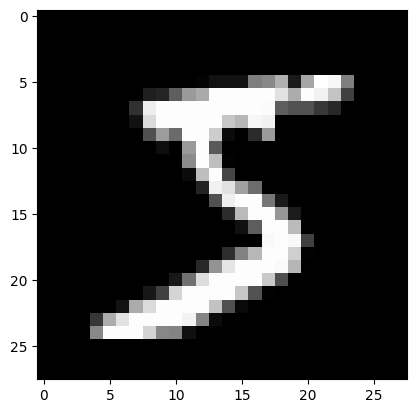

In [4]:
plt.imshow(training_data.data[0],cmap='gray')

In [5]:
# 데이터 로더 정의
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
# 평가용은 데이터를 섞을 필요가 없음
test_loader = DataLoader(training_data,batch_size=32,shuffle=False)

In [6]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [7]:

for i in train_loader:
  print(i[0].shape, i[1].shape)
  break


torch.Size([32, 1, 28, 28]) torch.Size([32])


In [8]:
# 학습모델 만들고 학습하기
# 모델정의 ->학습 ->손실계산 ->오차역전파 및 최적화(적용) ->반복 ->종료
import torch
import torch.nn as nn
from torch.optim.adam import Adam

In [9]:
28*28

784

In [ ]:
# cpu / gpu를 결정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Linear( 784 , 64 ),
    nn.ReLU(),
    nn.Linear( 64 , 64 ),
    nn.ReLU(),
    nn.Linear( 64 , 10 ),
    nn.Softmax()
)
model.to(device)  # 런타임 유형이 gpu이면 gpu이다

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

# 에포크만큼 학습
for epoch in range(20):
  # 배치만큼 --> loader
  for data,label in train_loader:
    optim.zero_grad()
    # 입력데이터를 설계대로 변경  입력 : 784
    data = torch.reshape(data, (-1,784)).to(device)
    # 학습 및 예측
    preds = model(data)
    # 오차(손실함수)
    loss = nn.CrossEntropyLoss()(preds, label.to(device)) # 해당 클래스의 __call__ 호출
    loss.backward()
    optim.step()
  print(f"epoch{epoch} loss:{loss.item()}")  # item() 실수형태로..

# 저장 : 확장자는 pth
torch.save(model.state_dict(),"MNIST.pth")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch0 loss:1.5317959785461426
